<a href="https://colab.research.google.com/github/pds2021/a5-chiZhang109/blob/assignment_5/Assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Practical Data Science 20/21*
# Programming Assignment 5 - Create your own App

In this programming assignment you'll build a model that serves as a foundation for your own app. To this end, you will create your own dataset, build a deep learning model on this data, and deploy it!

In [40]:
!pip install -Uqq fastai  # upgrade fastai on colab
from fastai.vision.all import *
from fastai.vision.widgets import *

__Google Drive integration__

If you want to store and access your downloaded data for this assignment you can use the following code:

In [18]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir /content/drive/My\ Drive/pds_a5
%cd /content/drive/My\ Drive/pds_a5

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/content/drive/My Drive/pds_a5’: File exists
/content/drive/My Drive/pds_a5


## Develop an Application Idea

___Free your mind - this part is totally up to you.___

Think of an app that you'd like to build.
*   What useful app have you been missing?
*   Do you have any hobbies an app could be helpful for?
*   Is this a suitable classification or regression task? 
*   How could you get the data?


In [ ]:
# Write down your app idea here

You can get an inspiration from these Apps:

<table>
<tr>
<td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/5.png"> <br><a href="https://forums.fast.ai/t/share-your-work-here/27676/400">Guitar Classifier</a> by Christian Werner</td><td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/6.png"><br><a href="https://forums.fast.ai/t/share-your-work-here/27676/340">Healthy or Not!</a> by Nikhil Utane </td><td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/7.png"> <br><a href="https://forums.fast.ai/t/share-your-work-here/27676/333">Hummingbird Classifier</a> by Nissan Dookeran</td>
</tr><tr>
<td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/8.png"> <br><a href="https://forums.fast.ai/t/share-your-work-here/27676/409">Edible Mushroom?</a> by Ramon</td><td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/9.png"><br> <a href="https://forums.fast.ai/t/share-your-work-here/27676/387">Cousin Recognizer</a> by Charlie Harrington</td><td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/10.png"><br> <a href="https://forums.fast.ai/t/share-your-work-here/27676/386">Emotion Classifier</a> by Ethan Sutin and Team 26</td>
</tr><tr>
<td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/11.png"> <br><a href="https://forums.fast.ai/t/share-your-work-here/27676/350">American Sign Language</a> by Keyur Paralkar</td><td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/12.png"> <br><a href="https://forums.fast.ai/t/share-your-work-here/27676/355">Your City from Space</a> by Henri Palacci</td><td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/13.png"> <br><a href="https://forums.fast.ai/t/share-your-work-here/27676/367">Univariate TS as images using Gramian Angular Field</a> by Ignacio Oguiza</td>
</tr><tr>
<td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/14.png"> <br><a href="https://forums.fast.ai/t/share-your-work-here/27676/348">Face Expression Recognition</a> by Pierre Guillou</td><td> <img src="https://github.com/hiromis/notes/raw/master/lesson3/15.png"><br><a href="https://forums.fast.ai/t/share-your-work-here/27676/352">Tumor-normal sequencing</a> by Alena Harley</td><td>  </td>
</tr><table>

## Creating your own Dataset

Now you need to construct a dataset that allows you to train a model for your app. You learned about how to create a dataset in Lecture 7.

Here, you can follow the steps from the lecture or look into the following ressources:

*   A [tool](https://github.com/toffebjorkskog/ml-tools/blob/master/gi2ds.md) for excluding irrelevant images from Google Image Search results beforehand by @melonkernel
*   See this [post](https://www.christianwerner.net/tech/Build-your-image-dataset-faster/) about an alternative image downloader/cleaner by @cwerner
*   Of course, you can use your own data/images :) 

### 1. Dowload the data 
- You may use the helper functions from the lecture to get the image URLs
- Create a new folder at your defined `path`
- Use `download_image` to download the images into the corresponding (sub-)directories

In [19]:
import requests
import re
import json
from fastcore.foundation import L

def search_images_ddg(key,max_n=150):
    """Search for 'key' with DuckDuckGo and return a unique urls of 'max_n' images
    (Adopted from https://github.com/deepanprabhu/duckduckgo-images-api and 
    https://github.com/fastai/fastbook/blob/master/utils.py)
    """
    url        = 'https://duckduckgo.com/'
    params     = {'q':key}
    res        = requests.post(url,data=params)
    searchObj  = re.search(r'vqd=([\d-]+)\&',res.text)
    if not searchObj: print('Token Parsing Failed !'); return
    requestUrl = url + 'i.js'
    headers    = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:71.0) Gecko/20100101 Firefox/71.0',
                 'referer': 'https://duckduckgo.com/'}
    params     = (('l','us-en'),('o','json'),('q',key),('vqd',searchObj.group(1)),('f',',,,'),('p','1'),('v7exp','a'))
    urls       = []
    while True:
        try:
            res  = requests.get(requestUrl,headers=headers,params=params)
            data = json.loads(res.text)
            for obj in data['results']:
                urls.append(obj['image'])
                max_n = max_n - 1
                if max_n < 1: return L(set(urls))     # dedupe
            if 'next' not in data: return L(set(urls))
            requestUrl = url + data['next']
        except:
            pass

In [20]:
ims = search_images_ddg('Akita Inu')
len(ims)

128

In [21]:
pd.DataFrame({'urls':ims})

,urls
0,https://www.dog-breeds-expert.com/images/akita-inu-pup-500.jpg
1,http://puppytoob.com/wp-content/uploads/2016/10/Akita-Inu.jpg
2,http://globaldogbreeds.com/wp-content/uploads/2017/12/Akita-Inu-Images.jpg
3,https://thumbs.dreamstime.com/z/akita-inu-puppy-25985771.jpg
4,http://www.pets4homes.co.uk/images/classifieds/2014/02/06/549845/large/japanese-akita-inu-pups-top-quality-53406fdbe6c9b.JPG
...,...
123,https://www.topinspired.com/wp-content/uploads/2016/08/akita-inu.jpg
124,https://thesmartcanine.com/wp-content/uploads/2019/06/best-dog-crates-akita-inu.jpg
125,https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Fels.jpg/220px-Fels.jpg
126,https://i.ytimg.com/vi/yVqlxl8eqHs/maxresdefault.jpg


In [22]:
dest = 'akita.jpg'
download_url(ims[0], dest)

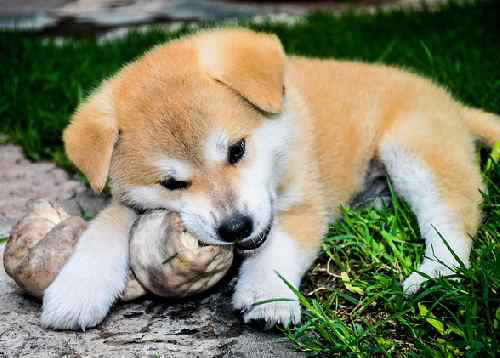

In [23]:
im = Image.open(dest)
im.to_thumb(512,512)

In [34]:
dog_types = 'akita','husky','shiba'
path = Path('dogs')

In [27]:
if not path.exists(): path.mkdir()
for o in dog_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_ddg(f'{o} dog')
    download_images(dest, urls=results)

### 2. Verify Images
- First, create a list of all your images
- Use `verify_images` and `unlink` to remove broken images

In [28]:
fns = get_image_files(path)
fns

(#370) [Path('dogs/akita/00000006.jpg'),Path('dogs/akita/00000003.jpg'),Path('dogs/akita/00000002.jpg'),Path('dogs/akita/00000001.jpg'),Path('dogs/akita/00000008.jpg'),Path('dogs/akita/00000009.jpg'),Path('dogs/akita/00000011.jpg'),Path('dogs/akita/00000010.jpg'),Path('dogs/akita/00000014.jpg'),Path('dogs/akita/00000013.jpg')...]

In [29]:
failed = verify_images(fns)
failed 

(#0) []

In [30]:
failed.map(Path.unlink)

(#0) []

### 3. Create the DataBlock
For this, you need to think of:
- What kinds of data we are working with
- How to get the list of items
- How to label these items
- How to create the validation set

Use `RandomResizedCrop` for `item_tfms`with an image size of 224 px, and the appropriate `aug_transforms` as `batch_tfms`.

In [31]:
dogs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

### 4. Create the DataLoaders

In [41]:
dls = dogs.dataloaders(path)

TypeError: ignored

### 5. Take a look at some of your pictures. 
Does everything look as expected?

In [ ]:
# Write your code here

## Modeling

### 6. Create a learner

Create an appropriate learner for your data
- Choose an appropriate model [architecture](https://fastai1.fast.ai/vision.models.html)
- Choose appropriate [metrics](https://docs.fast.ai/metrics.html) for your task

In [ ]:
# Write your code here

### 7. Fit the model

Use your knowdledge on model training to fit your model!

In [ ]:
# Write your code here

### 8. Evaluate the model

You' ve already seen many ways to evaluate a model. Evaluate your model in a qualitative and quantitative manner.

In [ ]:
# Write your code here

### 9. Clean your data

Based on the evaluation, you may want to clean your data using the `ImageClassifierCleaner`.
- Remeber to delete the selected data after using the cleaner:
    ```python
    for idx in cleaner.delete(): cleaner.fns[idx].unlink()
    ```
    
    
- Once we've cleaned up our data, we can retrain our model. 



In [ ]:
# Write your code here

## Turning Your Model into an Online Application

Now, take your app into production. You can follow the steps from the lecure:

- Export your model via `learn.export`
- Upload your model to [Github Releases](https://docs.github.com/en/free-pro-team@latest/github/administering-a-repository/about-releases) to make it publicly available at your repository.
- Create and upload a new notebook that only contains the necassary code and IPython widgets for your App. 
    - Remeber to download the exported model from *Github Releases*
    - Include a brief description of your app and the functionalities
- Publish your web app on [Binder](https://mybinder.org/) using Voilà

You can use the [example](https://github.com/pds2021/course/blob/main/nbs/07_Bear_App.ipynb) from the lecture as an orientation.

If you're familiar with the world of web application development, you're free to use these skills and all your tools and ressources!

In [ ]:
# Write your code here

## Finally, Provide a Link to Your App

In [ ]:
# Provide the link to your web app